In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
file_path = 'C:/Users/mertk/Documents/BDA_project/movielens100k/ml-100k/u.data'

df = pd.read_csv(file_path, sep='\t', header=None)

df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

df = df.drop(columns=['timestamp'])

print(df.head())

   user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


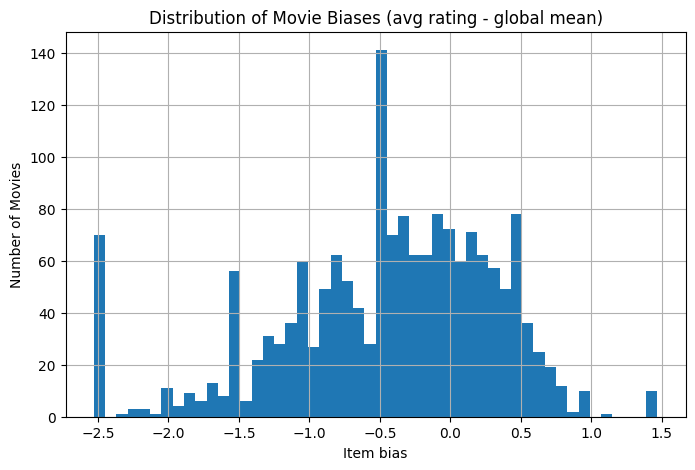

In [3]:
global_mu = df['rating'].mean() 

item_avg = df.groupby('item_id')['rating'].mean()

item_bias = item_avg - global_mu

# Plot
plt.figure(figsize=(8, 5))
item_bias.hist(bins=50)
plt.title("Distribution of Movie Biases (avg rating - global mean)")
plt.xlabel("Item bias")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

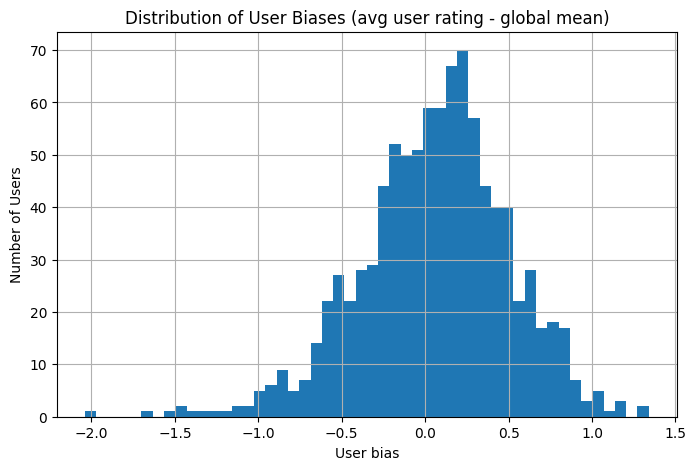

In [4]:
user_avg = df.groupby('user_id')['rating'].mean()

user_bias = user_avg - global_mu

# Plot
plt.figure(figsize=(8, 5))
user_bias.hist(bins=50)
plt.title("Distribution of User Biases (avg user rating - global mean)")
plt.xlabel("User bias")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

In [5]:
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_trainval, test_size=0.2, random_state=42)

In [6]:
def compute_rmse(df, P_mat, Q_mat, u_bias, i_bias, global_avg):
    errors = []
    for row in df.itertuples():
        u = row.user_id  
        i = row.item_id 
        r = row.rating
        pred = global_avg + u_bias[u] + i_bias[i] + np.dot(P_mat[u], Q_mat[i])
        err = r - pred
        errors.append(err ** 2)

    return np.sqrt(np.mean(errors))

In [7]:
def filter_known_users_items(df_val, user_map, item_map):
    """Keep only validation rows with users/items seen during training."""
    df_val = df_val.copy()
    df_val['user_id'] = df_val['user_id'].map(user_map)
    df_val['item_id'] = df_val['item_id'].map(item_map)
    return df_val.dropna().astype({'user_id': 'int', 'item_id': 'int'})

In [8]:
def manual_funksvd(df, df_val=None, lr_factor=0.01, lr_bias = 0.0025, reg=0.02, n_epochs=20, n_factors=20, verbose=True):
    
    df = df.copy()

    user_map = {old: new for new, old in enumerate(df['user_id'].unique())}
    item_map = {old: new for new, old in enumerate(df['item_id'].unique())}

    df['user_id'] = df['user_id'].map(user_map) # {'196': 0, '186': 1, '22': 2 ....}
    df['item_id'] = df['item_id'].map(item_map)

    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()

    mu = df['rating'].mean()

    # initialize biases as 0s
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)

    # initial random values for our item and user matrices
    # normally dist with mean = 0 and std dev = 0.1
    P = np.random.normal(0, 0.1, (n_users, n_factors))
    Q = np.random.normal(0, 0.1, (n_items, n_factors))

    train_rmse_list = []
    val_rmse_list = []

    if df_val is not None:
        df_val_filtered = filter_known_users_items(df_val, user_map, item_map)
    else:
        df_val_filtered = None

    for epoch in range(n_epochs):
        total_loss = 0
        for row in tqdm(df.itertuples(), total=len(df), desc=f"Epoch {epoch+1}"):
            u = row.user_id
            i = row.item_id
            r_ui = row.rating

            pred = mu + user_bias[u] + item_bias[i] + np.dot(P[u], Q[i])
            err = r_ui - pred

            # Update biases e.g; gamma*(e_ui*q_i - lambda*p_u)
            user_bias[u] += lr_bias * (err - reg * user_bias[u])
            item_bias[i] += lr_bias * (err - reg * item_bias[i])

            # Update latent factors  e.g; gamma*(e_ui*q_i - lambda*p_u)
            P[u] += lr_factor * (err * Q[i] - reg * P[u]) # we are updating the same vector like if user_id 166 appeared three times we update the same vector 3 times
            Q[i] += lr_factor * (err * P[u] - reg * Q[i])

            total_loss += err ** 2

        train_rmse = np.sqrt(total_loss / len(df))
        train_rmse_list.append(train_rmse)

        if verbose:
            print(f"Epoch {epoch+1}: Train RMSE={train_rmse:.4f}")

        if df_val_filtered is not None:
            val_rmse = compute_rmse(df_val_filtered, P, Q, user_bias, item_bias, mu)
            val_rmse_list.append(val_rmse)
            if verbose:
                print(f"→ Validation RMSE: {val_rmse:.4f}")

    return P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list


In [10]:
P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                                    df_val, 
                                                                                                    lr_factor = 0.01, 
                                                                                                    lr_bias = 0.0025,
                                                                                                    reg = 0.02, 
                                                                                                    n_epochs = 20,
                                                                                                    n_factors = 20,
                                                                                                    verbose=True)

Epoch 1: 100%|██████████| 64000/64000 [00:01<00:00, 35730.60it/s]


Epoch 1: Train RMSE=1.0845
→ Validation RMSE: 1.0435


Epoch 2: 100%|██████████| 64000/64000 [00:01<00:00, 39375.32it/s]


Epoch 2: Train RMSE=1.0252
→ Validation RMSE: 1.0102


Epoch 3: 100%|██████████| 64000/64000 [00:01<00:00, 32186.65it/s]


Epoch 3: Train RMSE=0.9936
→ Validation RMSE: 0.9921


Epoch 4: 100%|██████████| 64000/64000 [00:01<00:00, 35205.18it/s]


Epoch 4: Train RMSE=0.9730
→ Validation RMSE: 0.9808


Epoch 5: 100%|██████████| 64000/64000 [00:02<00:00, 26335.18it/s]


Epoch 5: Train RMSE=0.9571
→ Validation RMSE: 0.9729


Epoch 6: 100%|██████████| 64000/64000 [00:02<00:00, 22077.82it/s]


Epoch 6: Train RMSE=0.9435
→ Validation RMSE: 0.9669


Epoch 7: 100%|██████████| 64000/64000 [00:02<00:00, 30857.66it/s]


Epoch 7: Train RMSE=0.9305
→ Validation RMSE: 0.9619


Epoch 8: 100%|██████████| 64000/64000 [00:02<00:00, 29374.89it/s]


Epoch 8: Train RMSE=0.9172
→ Validation RMSE: 0.9575


Epoch 9: 100%|██████████| 64000/64000 [00:05<00:00, 12789.59it/s]


Epoch 9: Train RMSE=0.9028
→ Validation RMSE: 0.9534


Epoch 10: 100%|██████████| 64000/64000 [00:04<00:00, 15624.76it/s]


Epoch 10: Train RMSE=0.8872
→ Validation RMSE: 0.9496


Epoch 11: 100%|██████████| 64000/64000 [00:03<00:00, 19929.09it/s]


Epoch 11: Train RMSE=0.8702
→ Validation RMSE: 0.9463


Epoch 12: 100%|██████████| 64000/64000 [00:03<00:00, 18098.26it/s]


Epoch 12: Train RMSE=0.8524
→ Validation RMSE: 0.9438


Epoch 13: 100%|██████████| 64000/64000 [00:03<00:00, 18471.95it/s]


Epoch 13: Train RMSE=0.8343
→ Validation RMSE: 0.9422


Epoch 14: 100%|██████████| 64000/64000 [00:02<00:00, 28864.10it/s]


Epoch 14: Train RMSE=0.8163
→ Validation RMSE: 0.9417


Epoch 15: 100%|██████████| 64000/64000 [00:01<00:00, 36831.35it/s]


Epoch 15: Train RMSE=0.7988
→ Validation RMSE: 0.9421


Epoch 16: 100%|██████████| 64000/64000 [00:01<00:00, 37477.27it/s]


Epoch 16: Train RMSE=0.7820
→ Validation RMSE: 0.9433


Epoch 17: 100%|██████████| 64000/64000 [00:01<00:00, 34449.99it/s]


Epoch 17: Train RMSE=0.7659
→ Validation RMSE: 0.9453


Epoch 18: 100%|██████████| 64000/64000 [00:01<00:00, 37911.82it/s]


Epoch 18: Train RMSE=0.7507
→ Validation RMSE: 0.9477


Epoch 19: 100%|██████████| 64000/64000 [00:01<00:00, 35890.37it/s]


Epoch 19: Train RMSE=0.7363
→ Validation RMSE: 0.9506


Epoch 20: 100%|██████████| 64000/64000 [00:01<00:00, 35293.81it/s]


Epoch 20: Train RMSE=0.7227
→ Validation RMSE: 0.9538


In [12]:
lr_factor_list = [0.005, 0.01] 
lr_bias_list = [0.0025, 0.005]            
reg_list = [0.01, 0.02]             
n_epoch_list = [20, 40]             
n_factors_list = [20, 30, 50] 

In [ ]:
def grid_search(lr_factor_list, lr_bias_list, reg_list, n_epoch_list, n_factors_list):
    results = []

    best_rmse = 10**10
    best_params = {}

    for lr_factor in lr_factor_list:
        for lr_bias in lr_bias_list:
            for reg in reg_list:
                for n_epoch in n_epoch_list:
                    for n_factor in n_factors_list: 
                        P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                            df_val, 
                                                                                            lr_factor = lr_factor,
                                                                                            lr_bias = lr_bias,
                                                                                            reg = reg, 
                                                                                            n_epochs = n_epoch, 
                                                                                            n_factors = n_factor,
                                                                                            verbose=False)
                        
                        results.append({
                            "factor_number": n_factor,
                            "factor_learning_rate": lr_factor,
                            "bias_learning_rate": lr_bias,
                            "regularization": reg,
                            "epochs_trained": n_epoch,
                            "rmse": val_rmse_list[-1]
                        })

                        if val_rmse_list[-1] < best_rmse:
                            best_rmse = val_rmse_list[-1]
                            best_params = {
                                "factor_number": n_factor,
                                "factor_learning_rate": lr_factor,
                                "bias_learning_rate": lr_bias,
                                "regularization": reg,
                                "epochs_trained": n_epoch
                            }

    print("\n Best Parameters:")
    print(best_params) 
    return best_params, results
                    
                    

In [ ]:
best_params, results = grid_search(lr_factor_list, lr_bias_list, reg_list, n_epoch_list, n_factors_list)

In [15]:
print(best_params)

{'factor_number': 30, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.005, 'regularization': 0.02, 'epochs_trained': 20}


In [16]:
print(results)

[{'factor_number': 20, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.9408219454676767}, {'factor_number': 30, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.94548468902212}, {'factor_number': 50, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.9453760932631352}, {'factor_number': 20, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 40, 'rmse': 0.9660001785784892}, {'factor_number': 30, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 40, 'rmse': 0.9751317460591978}, {'factor_number': 50, 'factor_learning_rate': 0.005, 'bias_learning_rate': 0.0025, 'regularization': 0.01, 'epochs_trained': 40, 'rmse': 0.983172181490529}, {'factor_number': 20, 'factor_learning_rate': 0.005, '

In [17]:
results_df = pd.DataFrame(results)

results_df.to_csv("grid_search_results.csv", index=False)

In [23]:
P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                                    df_val, 
                                                                                                    lr_factor = 0.005, 
                                                                                                    lr_bias = 0.005,
                                                                                                    reg = 0.02, 
                                                                                                    n_epochs = 20,
                                                                                                    n_factors = 30,
                                                                                                    verbose=True)

Epoch 1: 100%|██████████| 64000/64000 [00:01<00:00, 62142.71it/s]


Epoch 1: Train RMSE=1.0601
→ Validation RMSE: 1.0113


Epoch 2: 100%|██████████| 64000/64000 [00:01<00:00, 62156.15it/s]


Epoch 2: Train RMSE=0.9930
→ Validation RMSE: 0.9821


Epoch 3: 100%|██████████| 64000/64000 [00:01<00:00, 57002.42it/s]


Epoch 3: Train RMSE=0.9666
→ Validation RMSE: 0.9689


Epoch 4: 100%|██████████| 64000/64000 [00:01<00:00, 61125.15it/s]


Epoch 4: Train RMSE=0.9512
→ Validation RMSE: 0.9615


Epoch 5: 100%|██████████| 64000/64000 [00:01<00:00, 50779.65it/s]


Epoch 5: Train RMSE=0.9404
→ Validation RMSE: 0.9566


Epoch 6: 100%|██████████| 64000/64000 [00:01<00:00, 37503.15it/s]


Epoch 6: Train RMSE=0.9320
→ Validation RMSE: 0.9531


Epoch 7: 100%|██████████| 64000/64000 [00:04<00:00, 15575.12it/s]


Epoch 7: Train RMSE=0.9249
→ Validation RMSE: 0.9506


Epoch 8: 100%|██████████| 64000/64000 [00:03<00:00, 16632.59it/s]


Epoch 8: Train RMSE=0.9188
→ Validation RMSE: 0.9486


Epoch 9: 100%|██████████| 64000/64000 [00:03<00:00, 20367.62it/s]


Epoch 9: Train RMSE=0.9131
→ Validation RMSE: 0.9470


Epoch 10: 100%|██████████| 64000/64000 [00:02<00:00, 27932.06it/s]


Epoch 10: Train RMSE=0.9077
→ Validation RMSE: 0.9458


Epoch 11: 100%|██████████| 64000/64000 [00:02<00:00, 30577.76it/s]


Epoch 11: Train RMSE=0.9025
→ Validation RMSE: 0.9447


Epoch 12: 100%|██████████| 64000/64000 [00:02<00:00, 29222.04it/s]


Epoch 12: Train RMSE=0.8972
→ Validation RMSE: 0.9438


Epoch 13: 100%|██████████| 64000/64000 [00:01<00:00, 34390.05it/s]


Epoch 13: Train RMSE=0.8918
→ Validation RMSE: 0.9430


Epoch 14: 100%|██████████| 64000/64000 [00:01<00:00, 38958.38it/s]


Epoch 14: Train RMSE=0.8861
→ Validation RMSE: 0.9423


Epoch 15: 100%|██████████| 64000/64000 [00:01<00:00, 43006.12it/s]


Epoch 15: Train RMSE=0.8801
→ Validation RMSE: 0.9416


Epoch 16: 100%|██████████| 64000/64000 [00:01<00:00, 47182.66it/s]


Epoch 16: Train RMSE=0.8738
→ Validation RMSE: 0.9409


Epoch 17: 100%|██████████| 64000/64000 [00:01<00:00, 47095.23it/s]


Epoch 17: Train RMSE=0.8670
→ Validation RMSE: 0.9403


Epoch 18: 100%|██████████| 64000/64000 [00:01<00:00, 42359.51it/s]


Epoch 18: Train RMSE=0.8597
→ Validation RMSE: 0.9397


Epoch 19: 100%|██████████| 64000/64000 [00:01<00:00, 34500.76it/s]


Epoch 19: Train RMSE=0.8519
→ Validation RMSE: 0.9391


Epoch 20: 100%|██████████| 64000/64000 [00:02<00:00, 26307.96it/s]

Epoch 20: Train RMSE=0.8436
→ Validation RMSE: 0.9386


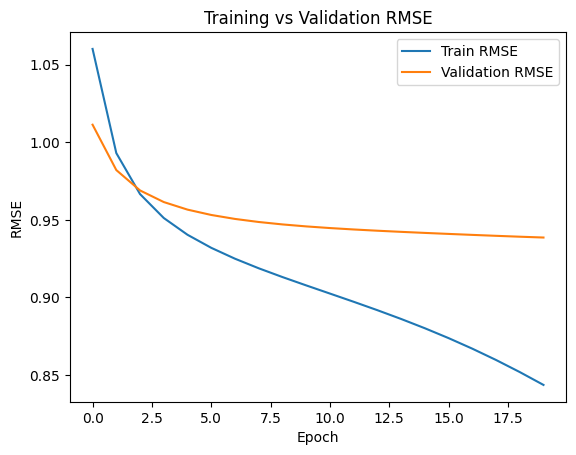

In [24]:
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(val_rmse_list, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation RMSE')
plt.show()

In [25]:
df_test_filtered = filter_known_users_items(df_test, user_map, item_map)
test_rmse = compute_rmse(df_test_filtered, P, Q, user_bias, item_bias, mu)

print("Test RMSE:", test_rmse)

Test RMSE: 0.9405605698842869
